# Sentiment Analysis

In [43]:
import enum
import pickle
from pprint import pprint
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from funciones_nlp import *

In [2]:
df = pd.read_csv('./data/reviews.csv')

In [3]:
df

,rating,review
0,50,This is one of the best hotels I've ever staye...
1,50,Everything about this hotel was awesome. The s...
2,50,Our tour group stayed here for two nights. Th...
3,50,Excellent service at Porta Hotel Antigua. From...
4,50,I almost always stay at Hotel Antigua when I t...
...,...,...
15677,40,Last week I stayed at the Camino Real in Antig...
15678,50,My boyfriend was in Guate on business and we d...
15679,40,I stayed at Camino Real Antigua for a conferen...
15680,50,"Was in Antigua for the weekend, attending an A..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15682 entries, 0 to 15681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  15682 non-null  int64 
 1   review  15682 non-null  object
dtypes: int64(1), object(1)
memory usage: 245.2+ KB


## Split

In [5]:
total_train, test = train_test_split(df, train_size=0.85,  random_state=2022)

Para obtener el set de validación, lo extraemos del set de entrenamiento

In [6]:
train, validation = train_test_split(total_train, train_size=0.828969415701948)

Para validar que las proporciones del set de entrenamiento, validación y prueba son correctas, realizaremos una comprobación rápida. Primero separamos en entrenamiento y prueba con una proporción de 85% - 15%

In [7]:
print(round(len(train) / len(df), 2))
print(round(len(validation) / len(df), 2))
print(round(len(test) / len(df), 2))

0.7
0.15
0.15


In [8]:
train

,rating,review
11112,40,The hotel was charming and romantic. Perfectl...
8018,50,We stayed at Meson Panza Verde for three night...
1664,50,Posada San Sebastián is beautiful! There are s...
13935,50,Stayed here for two nights. The staff goes out...
14989,50,Unfortunately we didn't plan enough in advance...
...,...,...
5985,40,This was once the best hotel in La Antigua Gua...
9724,50,Our family and friends stayed at D'Leyenda Hot...
1667,40,Myself and two chicas stayed here on New Years...
5649,50,Lovely hotel that is close to the busy parts o...


In [9]:
train_prep = prepare_data(train)

In [10]:
train_prep.sample(n = 10)

,rating,review,sentiment
6290,40,This lovely little hotel is in a fantastic loc...,Sentiments.POS
13054,50,Took a 2 night rest from studies/work and foun...,Sentiments.POS
13426,50,We stayed at The Good Hotel in Antigua after a...,Sentiments.POS
10272,40,What makes this hotel special is an exceptiona...,Sentiments.POS
2001,20,We booked this B&B because of the good feedbac...,Sentiments.NEG
1071,50,I stayed at Casa Encantada over Christmas and ...,Sentiments.POS
14888,50,We stayed here in February of 2016. This pr...,Sentiments.POS
943,50,The hotel is charming and flawlessly decorated...,Sentiments.POS
14443,50,First place we stayed on our trip and has been...,Sentiments.POS
14388,50,"The description ""House hotel"" might beconfusin...",Sentiments.POS


<AxesSubplot:>

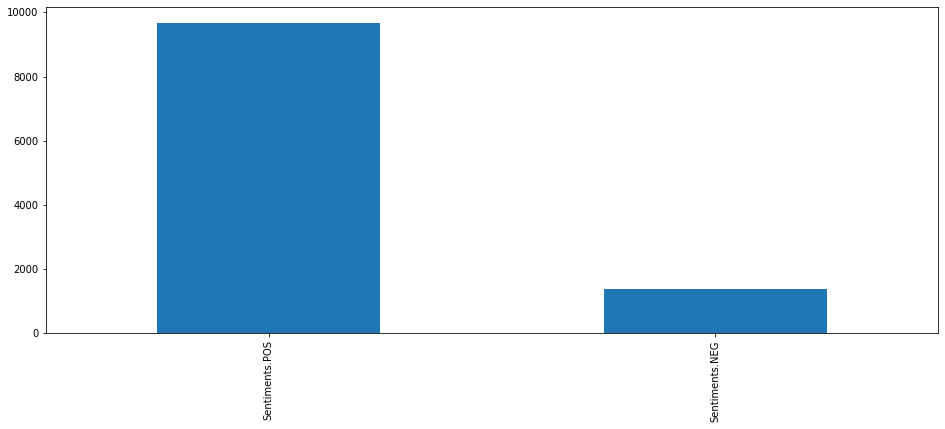

In [11]:
fig = plt.figure(figsize=(16,6))
train_prep['sentiment'].value_counts().plot(kind='bar')

## Crear diccionario

In [12]:
positive_reviews, negative_reviews = separar_clases(train_prep)

## Preprocesamiento

### Detección de bigramas

In [13]:
# 2.4 seg
positive_words = sentences_to_words(positive_reviews)
negative_words = sentences_to_words(negative_reviews)

In [14]:
# 3 min y 31 seg
positive_words_wo_stopwords = remove_stopwords(positive_words)
negative_words_wo_stopwords = remove_stopwords(negative_words)

Utiliza las palabras de todas las clases para aprender todos los bigramas dentro de todo el corpus.

### Tuning hiperparámetros

Para poder utilizar `model_selection.GridSearchCV` como método de tuning de hiperparámetros es necesario construir una clase que herede de la clase `BaseEstimator` y seguir una plantilla de manera minuciosa. A como indica la documentación: "La motivación principal para hacer que una clase sea compatible con la interfaz del estimador scikit-learn podría ser que deseemos usarla junto con herramientas de evaluación y selección de modelos, como model_selection.GridSearchCV y pipeline.Pipeline."  Fuente:  https://bit.ly/3OCpAs3

Debido a que este procedimiento no es trivial, optaremos por un método menos elegante, pero igual de efectivo.  Crearemos un cuadrícula de búsqueda con los hiperparámetros y realizaremos la iteración con todas las combinaciones posibles.

In [15]:
min_cont = [1, 5, 10]
umbral = [5, 10, 15]

Los parámetros de `min_count` y `threshold` están representados en la función por `c` y `t` respectivamente.

In [16]:
# 11.2 seg
modelos_bigramas = []
for x in min_cont:
    for y in umbral:
        modelos_bigramas.append(learn_bigrams(negative_words_wo_stopwords +
                                              positive_words_wo_stopwords, c = x, t = y))

In [17]:
modelos_bigramas

Hemos creado 9 modelos de bigramas, cada uno con una combinación específica de los parámetros `min_count` y `threshold`.

### Tokenización

**No correr el siguiente código.** Lo que hicimos fue dejar corriendo el modelo y luego guardamos los resultados en un pickle para evitar estar corriéndolo

Crearemos un modelo por cada modelo de bigrama creado en la parte de *tuning* de hiperparámetros:

In [ ]:
with open(r"./pkl/modelos.pkl", "rb") as input_file:
    modelos = pickle.load(input_file)

In [18]:
# 32 min y 30 seg (sin lematización)
# 60 min y 26 seg (con lematización)
modelos = []
for i in modelos_bigramas:
    modelos.append(entrenar_modelos(train_prep, i))

In [19]:
# with open(r"./pkl/modelos.pkl", "wb") as output_file:
#    pickle.dump(modelos, output_file)

In [21]:
len(modelos)

9

### Evaluación con set de Validación

Correremos de manera paralela el primer modelo de bigrama con el primer modelo calculado, y así suscesivamente de manera iterativa. El objetivo es crear una lista de DataFrames.  Importante notar que para esta tarea utilizaremos el dataset de **validación**.

In [ ]:
with open(r"./pkl/evaluacion_validacion.pkl", "rb") as input_file:
    val_res = pickle.load(input_file)

In [24]:
# 14 min
val_res = []
for (i, j) in itertools.zip_longest(modelos_bigramas, modelos):
    val_res.append(classified_data(validation, i, j))
    

In [29]:
# with open(r"./pkl/evaluacion_validacion.pkl", "wb") as output_file:
#    pickle.dump(val_res, output_file)

La lista resultante llamada `val_res` contiene dataframes con una columna de predicción en cada uno de ellos. Veamos el primero:

In [25]:
val_res[0]

,rating,review,y_pred,y_true
10416,50,This place was the perfect place to spend the ...,1,1
13968,50,This place has a great six bed dorm room (no b...,1,1
2168,40,Because its an older boutique hotel the room w...,1,1
9613,40,The rooms are very clean. The reading room and...,1,1
5385,50,Tropicana isn't for the faint hearted!! Had a ...,1,1
...,...,...,...,...
4532,50,"Great hostel with chill vibes, just what you n...",1,1
7743,50,We love the Porta!!! The people there are so v...,1,1
12104,50,The Good Hotel is a great place to lay your he...,1,1
13300,50,"Spacious rooms, all on one level, with high ce...",1,1


Ahora calcularemos las métricas obtenidas para cada modelo de bigrama y su correspondiente modelo de probabilidad.

In [27]:
puntuacion = []
for idx, dataset in enumerate(val_res):
    puntuacion.append(calcular_metricas(data_set=dataset, ind=idx))
score = pd.concat(puntuacion, axis=0)

## Selección del mejor modelo

In [28]:
score.sort_values(by=['recall'], ascending=False)

,bigrama,recall,precision,f1
0,0,0.951669,0.954523,0.953094
0,2,0.946687,0.960566,0.953576
0,1,0.944195,0.957554,0.950828
0,3,0.925262,0.967692,0.946001
0,7,0.924763,0.969191,0.946456
0,4,0.923269,0.966615,0.944444
0,5,0.923269,0.967624,0.944926
0,6,0.922770,0.971159,0.946346
0,8,0.922272,0.968096,0.944629


Precision-Recall es una medida útil del éxito de la predicción cuando las clases están muy desequilibradas, como en este caso. En la recuperación de información, la precisión es una medida de la relevancia de los resultados, mientras que el *recall* es una medida de cuántos resultados verdaderamente relevantes se devuelven.


Elegiremos el modelo con bigrama que se encuentra en la primera posición (0) debido a que es el que tiene el mejor recall.

## Evaluación con Set de Pruebas

In [33]:
test_res = classified_data(test, bigram_model=modelos_bigramas[0], model=modelos[0])

In [35]:
metricas_test = calcular_metricas(data_set=test_res, ind=0)

In [36]:
metricas_test

,bigrama,recall,precision,f1
0,0,0.956649,0.949251,0.952935


In [37]:
test_res

,rating,review,y_pred,y_true
15260,50,"If the town of Antigua were not so lovely, I'd...",1,1
403,40,"We really loved this hotel, the only slight do...",1,1
3120,50,"When I booked my stay here, it was really easy...",1,1
10464,50,My husband & I stayed here for 4 days when we ...,1,1
768,40,Stayed here (not Euro Maya Suites) for one nig...,1,1
...,...,...,...,...
9068,30,"Dirty, old and terrible service. I pay 97 us f...",0,0
1022,30,"The place is awesome, but service at Casa Sant...",1,0
3675,50,LISTEN TO ALL THE OTHER REVIEWS! This is defi...,0,1
6934,50,"The staff is fabulous, the hotel is charming, ...",1,1


In [40]:
cf_matrix = confusion_matrix(test_res.y_true, test_res.y_pred)
print(cf_matrix)

[[ 195  105]
 [  89 1964]]


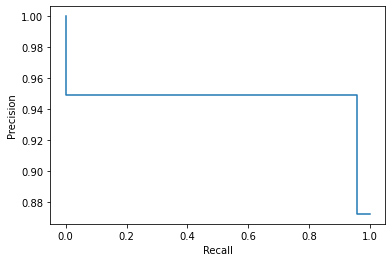

In [44]:
precision, recall, _ = precision_recall_curve(test_res.y_true, test_res.y_pred)
disp = PrecisionRecallDisplay(precision, recall)
disp.plot()

Esta gráfica nos permite ver a partir de qué recall tenemos una degradación de la precisión y viceversa. Lo ideal sería una curva que se acerque lo máximo posible a la esquina superior derecha (alta precisión y alto recall)

# Conclusiones

- Los resultados del conjunto de prueba son superiores en cuanto a recall y precisión que los del conjunto de entrenamiento, lo que significa que no tenemos **overfitting**.
- Tenemos una alta precisión y un alto recall en el conjunto de prueba, lo que significa que el modelo maneja muy bien esa clase (POS), a pesar de que los datos presentaron desbalance. El trade-off precision-recall es muy bueno a como podemos apreciar en la gráfica.
- El f1 score nos dice que la combinación de precisión y recall es muy buena.